# Chinook Music Store SQL Project

This report presents insights from an exploration of the Chinook Music Store database, hosted locally and queried using Python and MySQL.

## Goals
- Practice core SQL querying techniques
- Derive business-relevant insights
- Present findings in a clear, readable format

## Setup

Load relevant libraries and connect to the Chinook MySQL database.

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display

In [ ]:
# create connection
user = "your_username"
password = "your_password"
host = "localhost"
port = 3306
database = "chinook"

# Create the SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

---
## Examine database structure

Code blocks for examining the database's contents and the relationships between tables.

In [2]:
# get a list of the databases's tables
query = "SHOW TABLES"
df = pd.read_sql_query(query, engine)
print(df.Tables_in_chinook.tolist())

['album', 'artist', 'customer', 'employee', 'genre', 'invoice', 'invoiceline', 'mediatype', 'playlist', 'playlisttrack', 'track']


In [3]:
# examine individual table
query = "DESCRIBE invoice"
df = pd.read_sql_query(query, engine)
display(df)

,Field,Type,Null,Key,Default,Extra
0,InvoiceId,int,NO,PRI,None,
1,CustomerId,int,NO,MUL,None,
2,InvoiceDate,datetime,NO,,None,
3,BillingAddress,varchar(70),YES,,None,
4,BillingCity,varchar(40),YES,,None,
5,BillingState,varchar(40),YES,,None,
6,BillingCountry,varchar(40),YES,,None,
7,BillingPostalCode,varchar(10),YES,,None,
8,Total,"decimal(10,2)",NO,,None,


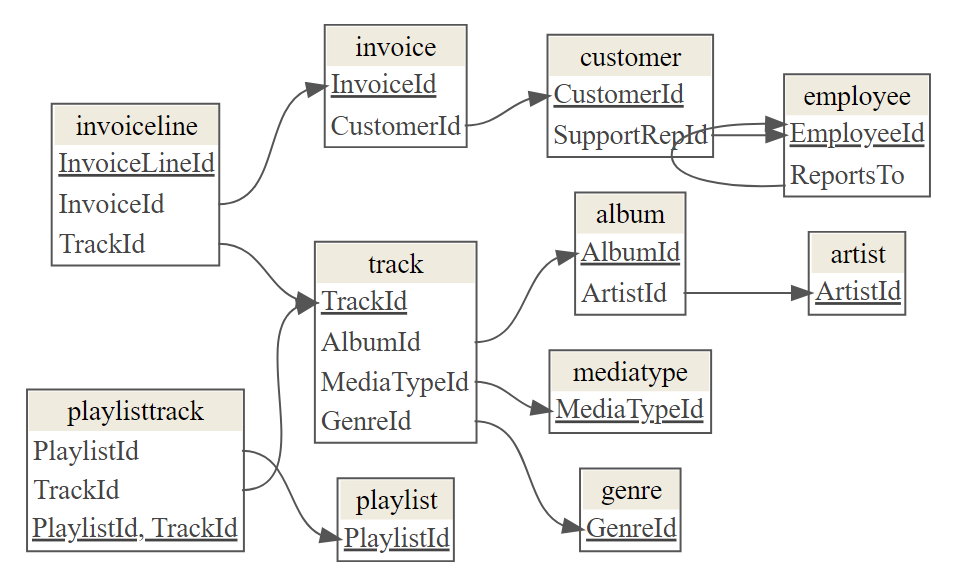

In [4]:
# import ERD diagram of the Chinook database (that I built in R)
from IPython.display import Image
Image(filename='.\\input\\ChinookDBStructure.png', width = 600, height = 400)

---
## What are the top 10 best-selling music artists?

Identify which music artists generated the most revenue globally.

In [5]:
# selecting top music artist
# explicitly excluding rows from the televison-related and Comedy genres, to focus on music artists
query = """
    SELECT ar.Name AS ArtistName,
    GROUP_CONCAT(DISTINCT ge.Name) AS Genres,
    SUM(il.UnitPrice * il.Quantity) AS TotalSales
    FROM invoiceline AS il
    JOIN track AS tr ON il.TrackID = tr.TrackID
    JOIN album AS al ON tr.AlbumID = al.AlbumID
    JOIN artist AS ar ON al.ArtistID = ar.ArtistID
    JOIN genre AS ge ON ge.GenreID = tr.GenreID
    WHERE ge.Name NOT IN ('TV Shows', 'Drama', 'Sci Fi & Fantasy', 'Comedy') 
    GROUP BY ar.Name
    ORDER BY TotalSales DESC
    LIMIT 10;  
"""
artist_sales = pd.read_sql_query(query, engine)
artist_sales

,ArtistName,Genres,TotalSales
0,Iron Maiden,"Blues,Heavy Metal,Metal,Rock",138.60
1,U2,"Pop,Rock",105.93
2,Metallica,Metal,90.09
3,Led Zeppelin,Rock,86.13
4,Os Paralamas Do Sucesso,Latin,44.55
5,Deep Purple,Rock,43.56
6,Faith No More,"Alternative & Punk,Rock",41.58
7,Eric Clapton,"Blues,Latin",39.60
8,R.E.M.,"Alternative & Punk,Rock",38.61
9,Queen,Rock,36.63


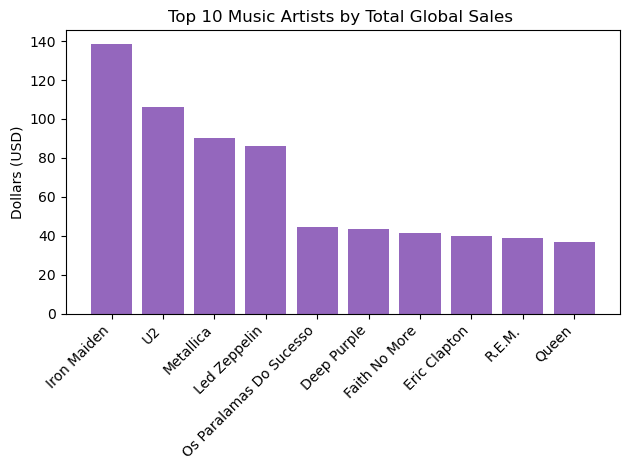

In [6]:
# bar chart of top selling artists
artist_sales['TotalSales'] = pd.to_numeric(artist_sales['TotalSales'], errors='coerce')
plt.bar(artist_sales['ArtistName'], artist_sales['TotalSales'], color = mcolors.TABLEAU_COLORS['tab:purple'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Dollars (USD)')
plt.title('Top 10 Music Artists by Total Global Sales ')
plt.rc('xtick', labelsize=9) 
plt.tight_layout()
plt.show()

## Summary Insights

- Rock artists dominate the top artists list suggesting this genre may have the widest appeal globally among the Chinook customer base.
- Metal artists occupy 2 of the top 3 positions.
- The absence of many other genres in this list (e.g., Classical, Jazz) suggests that there will be an uneven distribution of revenue across genres.
---
                                                          
## Next Step
                                                          
Examine global sales by music genre.

In [8]:
# estimate global sales by music genre
# explicitly excluding rows from the televison-related and Comedy genres, to focus on music artists
query = """
    SELECT ge.Name AS Genre,
    ROUND(SUM(il.UnitPrice * il.Quantity), 2) AS TotalSales
    FROM invoiceline AS il
    JOIN track AS tr ON il.TrackID = tr.TrackID
    JOIN genre AS ge ON tr.GenreID = ge.GenreID
    WHERE ge.Name NOT IN ('TV Shows', 'Drama', 'Sci Fi & Fantasy', 'Comedy') 
    GROUP BY ge.Name
    ORDER BY TotalSales DESC;  
"""
genre_sales = pd.read_sql_query(query, engine)
genre_sales

,Genre,TotalSales
0,Rock,826.65
1,Latin,382.14
2,Metal,261.36
3,Alternative & Punk,241.56
4,Jazz,79.20
5,Blues,60.39
6,R&B/Soul,40.59
7,Classical,40.59
8,Reggae,29.70
9,Pop,27.72


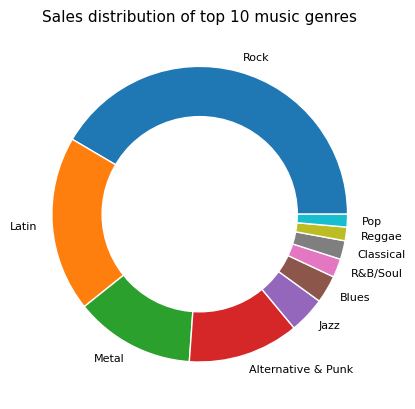

In [9]:
# donut chart of top 10 music genres in terms of global sales
gs = genre_sales.head(10)
circ = plt.Circle( (0,0), 0.66, color='white')
plt.pie(gs['TotalSales'], labels=gs['Genre'], 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' },
        textprops = {'fontsize': 8 }
       )
p = plt.gcf()
p.gca().add_artist(circ)
plt.title("Sales distribution of top 10 music genres", fontsize=11)
plt.show()

## Summary Insights

- As suggested by the top-selling artists, Rock and Metal are among strongest-selling genres globally.
- Latin and Alternative & Punk also show strong sales suggesting these genres are supported by a broader base of smaller artists.

---
    
## Next Step

Examine the monthly time course of global sales.

In [9]:
# exampine monthly global revenue trend
query = """
    SELECT YEAR(i.InvoiceDate) AS Year,
           MONTH(i.InvoiceDate) AS Month,
           SUM(i.Total) AS Revenue
    FROM invoice AS i
    GROUP BY YEAR(i.InvoiceDate), MONTH(i.InvoiceDate)
    ORDER BY YEAR(i.InvoiceDate), MONTH(i.InvoiceDate);
"""
monthly_sales = pd.read_sql_query(query, engine)
monthly_sales.head(12)

,Year,Month,Revenue
0,2021,1,35.64
1,2021,2,37.62
2,2021,3,37.62
3,2021,4,37.62
4,2021,5,37.62
5,2021,6,37.62
6,2021,7,37.62
7,2021,8,37.62
8,2021,9,37.62
9,2021,10,37.62


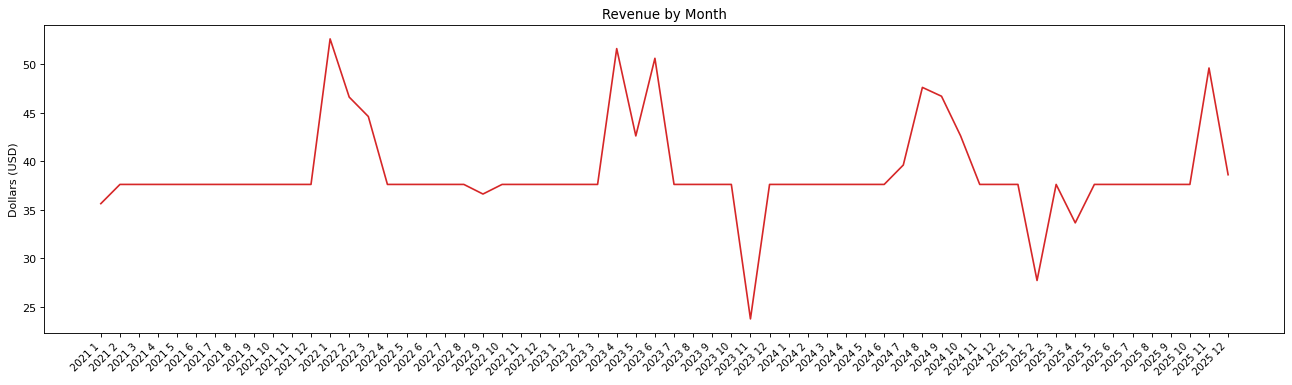

In [10]:
# line chart of global sales my month
figure(figsize=(20, 5), dpi=80)

monthly_sales['Revenue'] = pd.to_numeric(monthly_sales['Revenue'], errors='coerce')
monthly_sales['YearMonth'] = monthly_sales['Year'].map(str) + ' ' + monthly_sales['Month'].map(str)
plt.plot(monthly_sales['YearMonth' ], monthly_sales['Revenue'], color = mcolors.TABLEAU_COLORS['tab:red'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Dollars (USD)')
plt.title('Revenue by Month')
plt.show()

## Summary Insights

- The Chinook database appears to have synthetic revenue data. As shown above, monthly revenue is unrealistically flat across many time ranges, suggesting placeholder values rather than realistic sales trends. Nonetheless, I include this example to demonstrate the use of SQL for grouping and aggregating data by time.

---
## Next Step

Examine total sales data by country.

In [11]:
# calculate the total numer of customers and the total sales in each country
query = """
    SELECT c.Country,
           COUNT(DISTINCT c.CustomerID) AS NumberOfCustomers,
           SUM(il.UnitPrice * il.Quantity) AS TotalSpend 
    FROM customer AS c
    JOIN invoice AS i ON c.CustomerID = i.CustomerID
    JOIN invoiceline AS il ON i.InvoiceID = il.InvoiceID
    JOIN track AS tr ON il.TrackID = tr.TrackID
    JOIN genre AS ge ON tr.GenreID = ge.GenreID
    WHERE ge.Name NOT IN ('TV Shows', 'Drama', 'Sci Fi & Fantasy', 'Comedy') 
    GROUP BY c.Country
    ORDER BY SUM(i.Total) DESC, COUNT(c.CustomerID) DESC; 
"""
country_sales = pd.read_sql_query(query, engine)
country_sales.head(24)

,Country,NumberOfCustomers,TotalSpend
0,USA,13,457.39
1,Canada,8,297.99
2,Brazil,5,186.12
3,France,5,181.17
4,Germany,4,148.52
5,United Kingdom,3,112.86
6,Portugal,2,73.26
7,India,2,71.28
8,Czech Republic,2,62.38
9,Argentina,1,37.62


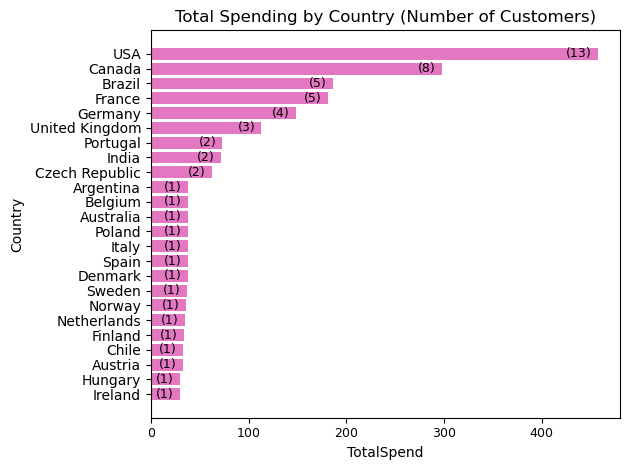

In [12]:
# horizontal bar chart of total spending of each country on music artists
# number of customers per country shown in parenthesis on heach bar

# Function to add value labels on top of bars
def add_labels(x, y, labels):
    for i in range(len(x)):
        label = f"({labels[i]})"
        plt.text(x[i] - 6, y[i], label, va='center', ha='right', fontsize=9, color='black')

# reorder above query dataframe rows to for visualization
df = country_sales.sort_values(by="TotalSpend", ascending=True)

# plot horizontal bars
plt.barh(df['Country'], df['TotalSpend'], color= mcolors.TABLEAU_COLORS['tab:pink'])
y_positions = range(len(df))
plt.ylabel("Country")
add_labels(df['TotalSpend'].values, y_positions, df['NumberOfCustomers'].values)
plt.xlabel("TotalSpend") 
plt.title("Total Spending by Country (Number of Customers)")
plt.tight_layout()
plt.show()

## Summary Insights

- The USA has the most customers and most sales of all countries.
- Most countries have only one customer
---

## Next Step

Examine the relationship between Country and Genre. Do different countries display distinct genre profiles ?

In [13]:
# perform group by calculation with Country and Genre
# constraining data to top 6 countries and the top 4 genres for cleaner visuals; full data available if needed

query = """
SELECT 
    i.BillingCountry AS Country,
    ge.Name AS Genre,
    ROUND(SUM(il.UnitPrice * il.Quantity), 2) AS TotalSales
FROM invoice AS i
JOIN invoiceline AS il ON i.InvoiceID = il.InvoiceID
JOIN track AS tr ON il.TrackID = tr.TrackID
JOIN genre AS ge ON tr.GenreID = ge.GenreID
JOIN (
    SELECT ge.Name
    FROM invoiceline AS il
    JOIN track AS tr ON il.TrackID = tr.TrackID
    JOIN genre AS ge ON tr.GenreID = ge.GenreID
    GROUP BY ge.Name
    ORDER BY SUM(il.UnitPrice * il.Quantity) DESC
    LIMIT 4
) AS top_genres ON ge.Name = top_genres.Name
JOIN (
    SELECT i.BillingCountry
    FROM invoice AS i
    JOIN invoiceline AS il ON i.InvoiceID = il.InvoiceID
    GROUP BY i.BillingCountry
    ORDER BY SUM(il.UnitPrice * il.Quantity) DESC
    LIMIT 6
) AS top_countries ON i.BillingCountry = top_countries.BillingCountry
GROUP BY i.BillingCountry, ge.Name
ORDER BY Country, Genre;
"""

country_by_genre = pd.read_sql_query(query, engine)
country_by_genre

,Country,Genre,TotalSales
0,Brazil,Alternative & Punk,6.93
1,Brazil,Latin,52.47
2,Brazil,Metal,14.85
3,Brazil,Rock,80.19
4,Canada,Alternative & Punk,35.64
5,Canada,Latin,59.40
6,Canada,Metal,39.60
7,Canada,Rock,105.93
8,France,Alternative & Punk,30.69
9,France,Latin,25.74


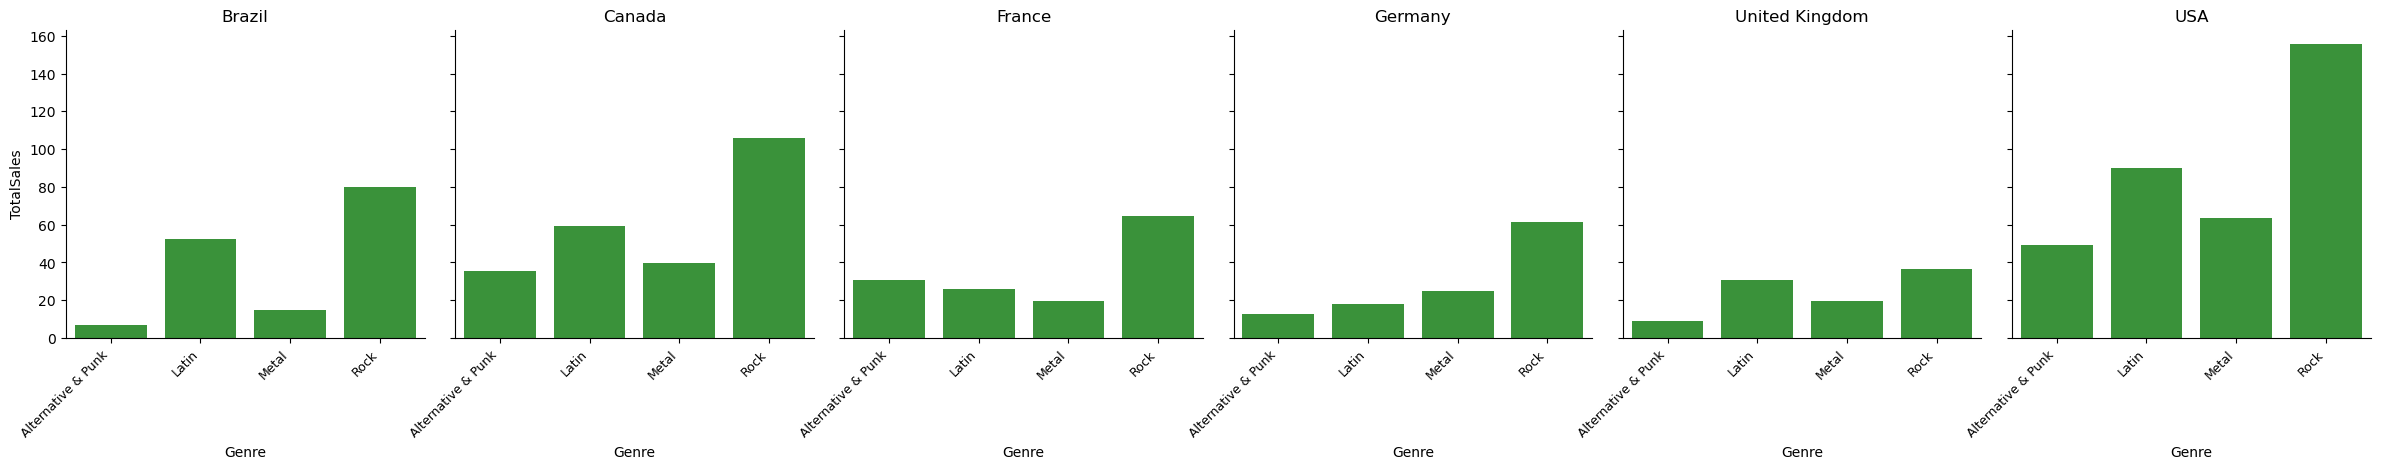

In [16]:
# plot total revenue by genre for each country
p = sns.catplot(
    data=country_by_genre,
    x="Genre", 
    y="TotalSales", 
    col="Country",
    kind="bar",
    height=4, 
    aspect=1,
    col_wrap = 6,
    color= mcolors.TABLEAU_COLORS['tab:green']
)

for ax in p.axes.flat:
    ax.set_title(ax.get_title().split('=')[1].strip())

for ax in p.axes.flat:  
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  # align right so they don’t overlap

#plt.tight_layout()   
plt.show()

## Summary Insights

- The Rock genre dominates sales across all six countires, making it the most purchased genre.
- This suggests that the Chinook Music Store has a strong appeal among rock music fans, and that rock is an important feature for customer engagement and revenue globally.
---

## Next Step

Visualize whether the different countries have unique genre preferences

In [17]:
# convert to numeric
country_by_genre['TotalSales'] = pd.to_numeric(country_by_genre['TotalSales'], errors='coerce')

# Calulate percentages by country
country_by_genre['TotalSalesByCountry'] = country_by_genre.groupby('Country')['TotalSales'].transform('sum')
country_by_genre['Percentage'] = country_by_genre['TotalSales']/country_by_genre['TotalSalesByCountry'] * 100
country_by_genre = country_by_genre.drop(columns = 'TotalSalesByCountry')

display(country_by_genre)

,Country,Genre,TotalSales,Percentage
0,Brazil,Alternative & Punk,6.93,4.487179
1,Brazil,Latin,52.47,33.974359
2,Brazil,Metal,14.85,9.615385
3,Brazil,Rock,80.19,51.923077
4,Canada,Alternative & Punk,35.64,14.814815
5,Canada,Latin,59.40,24.691358
6,Canada,Metal,39.60,16.460905
7,Canada,Rock,105.93,44.032922
8,France,Alternative & Punk,30.69,21.830986
9,France,Latin,25.74,18.309859


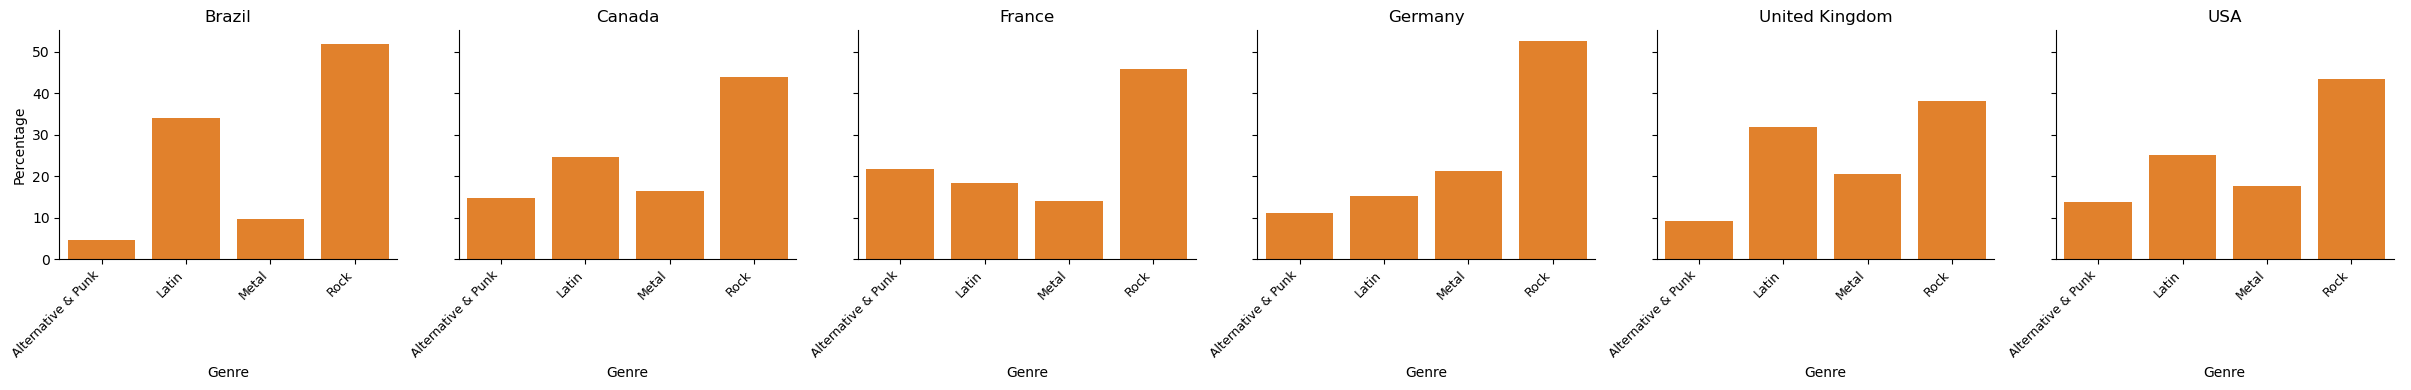

In [18]:
p = sns.catplot(
    data= country_by_genre,
    x="Genre", y="Percentage", 
    col="Country",
    kind="bar",
    height=4, aspect=1,
    col_wrap = 6,
    color = mcolors.TABLEAU_COLORS['tab:orange']
)

for ax in p.axes.flat:
    ax.set_title(ax.get_title().split('=')[1].strip())

for ax in p.axes.flat:  
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right') 
        
plt.tight_layout()    
plt.show()

## Summary Insights

- Rock is the top-selling genre overall, but country-specific preferences exist.


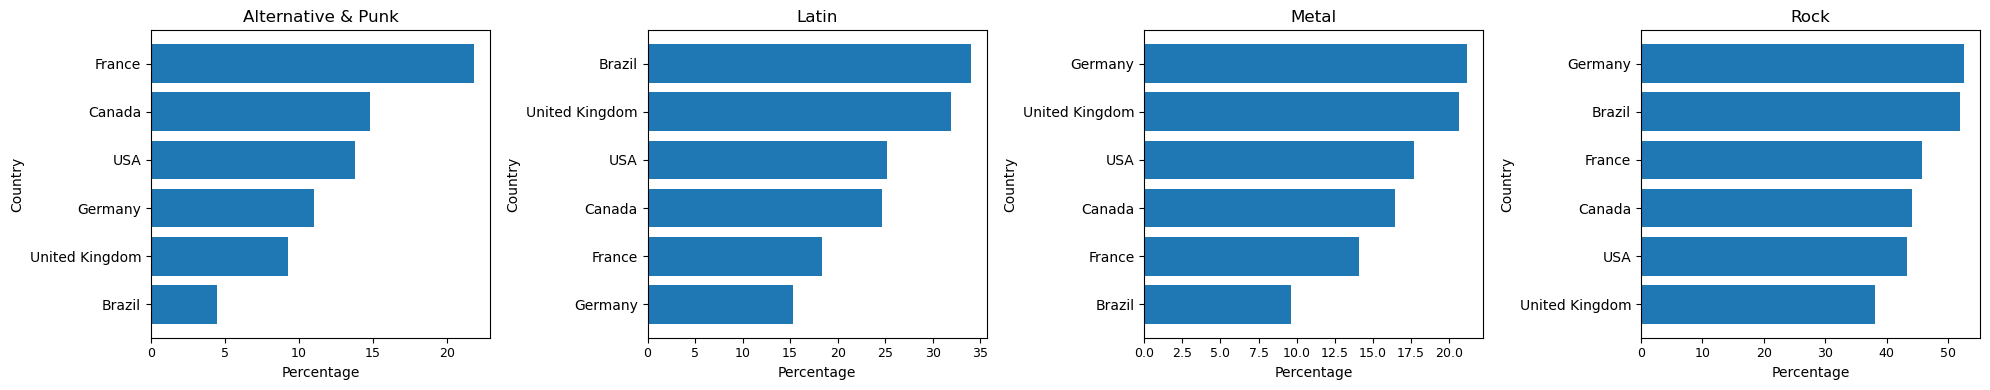

In [19]:
# horizontal bar charts for each genre and the six countries
genres = country_by_genre['Genre'].unique()
n_cols = 4
n_rows = (len(genres) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, genre in enumerate(genres):
    ax = axes[i]
    sub_df = country_by_genre[country_by_genre['Genre'] == genre].copy()
    # Sort descending by Percentage
    sub_df = sub_df.sort_values('Percentage', ascending=True)  # ascending=True because barh plots from bottom
    
    ax.barh(sub_df['Country'], sub_df['Percentage'], color= mcolors.TABLEAU_COLORS['tab:blue'])
    ax.set_title(f"{genre}")
    ax.set_xlabel("Percentage")
    ax.set_ylabel("Country")

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Summary Insights

- These patterns support the existence of country specific preferences.
    Examples:
    - DE: shows the highest percentage purchases for both Rock and Metal genres
    - BR: shows the highest percentage of Latin genre purchases
    - FR: leads with the highest percentage of Alternative & Punk genre purchases
- Genre-specific outreach could elevate customer engagement and increase sales in targeted markets.
---

## Main Take Aways

- Rock dominates globally, making it the most relevant genre for Chinook's global marketing efforts. 
- Country-specific preferences in the genres of Alternative & Punk, Latin, and Metal point to opportunities for localized marketing campaigns to increase customer engagement and sales.
- Note: This analysis is based on a small, fictional dataset. It is intended as a technical exercise in SQL and exploratory analysis, not as real-world business advice.